In [46]:
from fredapi import Fred
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score
pd.options.plotting.backend = "plotly"
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
import plotly.graph_objects as go


# BACKTESTING

Backtesting is one of the most essential, and yet least understood, techniques in the  
quant arsenal. A common misunderstanding is to think of backtesting as a research  
tool. Researching and backtesting is like drinking and driving. Do not research under  
the influence of a backtest. Most backtests published in journals are flawed, as the  
result of selection bias on multiple tests

## MISSION IMPOSSIBLE: THE FLAWLESS BACKTEST

In its narrowest definition, a backtest is a historical simulation of how a strategy would  
have performed should it have been run over a past period of time. As such, it is a  
hypothetical, and by no means an experiment.
### A backtest guarantees nothing
### An ex-post story

## FEW GENERAL RECOMMENDATIONS
### - Develop models for entire asset class, not only selected securities
### - Apply bagging - prevents overfitting 
### - Do not apply backtest as intermediate step - only backtest when you have your full strategy ready
### - Record every backtest 
### - Simulate scenarios rather than history - it is a lot harder to overfit with 1000s of 'what-if'   scenarios than just a simple historical backtest

## STRATEGY SELECTION
### - Validation procedure - you must validate the model on observations that are least likely to  be correlated with the train dataset
#### - Cross-Validation - all factors must be strictly point-in-time with no possibility for look-ahead bias
#### - Walking forward - testing one observation away may not be sufficient
#### - Grouped Cross-Validation - create groups and validate one strategy on multiple groups




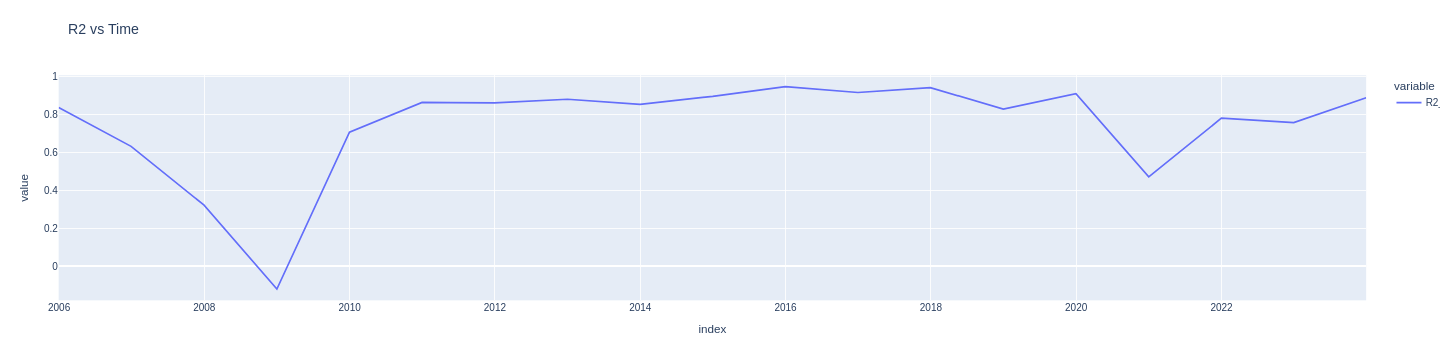

In [2]:
def data_load_yahoo(_ticker='^GSPC'):

    # Define the ticker symbol and the period
    ticker = _ticker
    period = 'max'
    start = '1985-01-25'
    interval = '1mo'

    # Create an instance of the Ticker class
    sp500_ticker = yf.Ticker(ticker)

    # Get historical monthly data
    monthly_data = sp500_ticker.history(period=period,interval=interval,start=start)

    # Print the first few rows of the data
    monthly_data.index = monthly_data.index+pd.offsets.BMonthEnd()

    # Save SP500 data to csv
    #monthly_data.to_csv('SP500_monthly_dividend.csv')
    return monthly_data

In [102]:
#add SP500 data from yahoofinance
sp_div_df = data_load_yahoo('^GSPC')
sp_div_df['MonthEnd'] = pd.to_datetime(sp_div_df.index.strftime('%Y-%m-%d'))-pd.DateOffset(days=1)+pd.offsets.BMonthEnd()
sp_div_df['sp_return_1m'] = ((sp_div_df['Dividends']+sp_div_df['Close']-sp_div_df['Close'].shift(1)))/sp_div_df['Close'].shift(1)*10000000
sp_div_df['sp_return_3m'] = ((sp_div_df['Close']-sp_div_df['Close'].shift(3)))/sp_div_df['Close'].shift(3)*10000000
sp_div_df['sp_return_6m'] = ((sp_div_df['Close']-sp_div_df['Close'].shift(6)))/sp_div_df['Close'].shift(6)*10000000
sp_div_df['sp_return_12m'] = ((sp_div_df['Close']-sp_div_df['Close'].shift(12)))/sp_div_df['Close'].shift(12)*10000000

vix_df = data_load_yahoo(_ticker='^VIX')
vix_df['MonthEnd'] = pd.to_datetime(vix_df.index.strftime('%Y-%m-%d'))-pd.DateOffset(days=1)+pd.offsets.BMonthEnd()
vix_df['vix_diff_3m'] = ((vix_df['Close']-vix_df['Close'].shift(3)))/vix_df['Close'].shift(3)*10000000
vix_df['vix_diff_6m'] = ((vix_df['Close']-vix_df['Close'].shift(6)))/vix_df['Close'].shift(6)*10000000
vix_df['vix_diff_12m'] = ((vix_df['Close']-vix_df['Close'].shift(12)))/vix_df['Close'].shift(12)*10000000
vix_df = vix_df.rename(columns={'Close':'VIX'})

sp_div_df = data_load_yahoo('^GSPC')
sp_div_df['MonthEnd'] = pd.to_datetime(sp_div_df.index.strftime('%Y-%m-%d'))-pd.DateOffset(days=1)+pd.offsets.BMonthEnd()
sp_div_df['sp_return_1m'] = ((sp_div_df['Dividends']+sp_div_df['Close']-sp_div_df['Close'].shift(1)))/sp_div_df['Close'].shift(1)*10000000
sp_div_df['sp_return_3m'] = ((sp_div_df['Close']-sp_div_df['Close'].shift(3)))/sp_div_df['Close'].shift(3)*10000000
sp_div_df['sp_return_6m'] = ((sp_div_df['Close']-sp_div_df['Close'].shift(6)))/sp_div_df['Close'].shift(6)*10000000
sp_div_df['sp_return_12m'] = ((sp_div_df['Close']-sp_div_df['Close'].shift(12)))/sp_div_df['Close'].shift(12)*10000000

r200_df = data_load_yahoo('^RUT')
r200_df['MonthEnd'] = pd.to_datetime(r200_df.index.strftime('%Y-%m-%d'))-pd.DateOffset(days=1)+pd.offsets.BMonthEnd()
r200_df['sp_return_1m'] = ((r200_df['Dividends']+r200_df['Close']-r200_df['Close'].shift(1)))/r200_df['Close'].shift(1)*10000000
r200_df['sp_return_3m'] = ((r200_df['Close']-r200_df['Close'].shift(3)))/r200_df['Close'].shift(3)*10000000
r200_df['sp_return_6m'] = ((r200_df['Close']-r200_df['Close'].shift(6)))/r200_df['Close'].shift(6)*10000000
r200_df['sp_return_12m'] = ((r200_df['Close']-r200_df['Close'].shift(12)))/r200_df['Close'].shift(12)*10000000

gold_df = data_load_yahoo('GC=F')
gold_df['MonthEnd'] = pd.to_datetime(gold_df.index.strftime('%Y-%m-%d'))-pd.DateOffset(days=1)+pd.offsets.BMonthEnd()
gold_df['sp_return_1m'] = ((gold_df['Close']-gold_df['Close'].shift(1)))/gold_df['Close'].shift(1)*10000000
gold_df['sp_return_3m'] = ((gold_df['Close']-gold_df['Close'].shift(3)))/gold_df['Close'].shift(3)*10000000
gold_df['sp_return_6m'] = ((gold_df['Close']-gold_df['Close'].shift(6)))/gold_df['Close'].shift(6)*10000000
gold_df['sp_return_12m'] = ((gold_df['Close']-gold_df['Close'].shift(12)))/gold_df['Close'].shift(12)*10000000

btc_usd_df = data_load_yahoo('GC=F')
btc_usd_df['MonthEnd'] = pd.to_datetime(gold_df.index.strftime('%Y-%m-%d'))-pd.DateOffset(days=1)+pd.offsets.BMonthEnd()
btc_usd_df['sp_return_1m'] = ((btc_usd_df['Close']-btc_usd_df['Close'].shift(1)))/btc_usd_df['Close'].shift(1)*10000000
btc_usd_df['sp_return_3m'] = ((btc_usd_df['Close']-btc_usd_df['Close'].shift(3)))/btc_usd_df['Close'].shift(3)*10000000
btc_usd_df['sp_return_6m'] = ((btc_usd_df['Close']-btc_usd_df['Close'].shift(6)))/btc_usd_df['Close'].shift(6)*10000000
btc_usd_df['sp_return_12m'] = ((btc_usd_df['Close']-btc_usd_df['Close'].shift(12)))/btc_usd_df['Close'].shift(12)*10000000

In [103]:
btc_usd_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthEnd,sp_return_1m,sp_return_3m,sp_return_6m,sp_return_12m
Date,,,,,,,,,,,,
2000-08-31 00:00:00-04:00,273.899994,278.299988,273.899994,278.299988,0,0.0,0.0,2000-08-31,NaN,NaN,NaN,NaN
2000-09-29 00:00:00-04:00,277.000000,278.399994,269.000000,273.600006,4291,0.0,0.0,2000-09-29,-1.688819e+05,NaN,NaN,NaN
2000-11-30 00:00:00-05:00,263.899994,270.200012,263.899994,270.100006,32465,0.0,0.0,2000-11-30,-1.279240e+05,NaN,NaN,NaN
2000-12-29 00:00:00-05:00,269.700012,276.000000,268.000000,272.000000,1664,0.0,0.0,2000-12-29,7.034409e+04,-2.263740e+05,NaN,NaN
2001-01-31 00:00:00-05:00,268.399994,268.399994,262.799988,265.600006,17811,0.0,0.0,2001-01-31,-2.352939e+05,-2.923977e+05,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 00:00:00-05:00,2818.199951,2957.899902,2780.899902,2836.800049,46632,0.0,0.0,2025-02-28,8.640017e+04,3.597122e+05,2.187138e+06,3.754850e+06
2025-03-31 00:00:00-04:00,2872.699951,3132.500000,2863.399902,3122.800049,168341,0.0,0.0,2025-03-31,1.008178e+06,1.753105e+06,2.869565e+06,5.245070e+06
2025-04-30 00:00:00-04:00,3129.699951,3485.600098,2949.699951,3305.000000,38612,0.0,0.0,2025-04-30,5.834506e+05,1.751111e+06,3.252867e+06,6.155839e+06


In [101]:
r200_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthEnd,sp_return_1m,sp_return_3m,sp_return_6m,sp_return_12m
Date,,,,,,,,,,,,
1987-09-30 00:00:00-04:00,167.440002,170.949997,166.690002,170.809998,2627700000,0.0,0.0,1987-09-30,NaN,NaN,NaN,NaN
1987-10-30 00:00:00-05:00,170.820007,172.619995,105.459999,118.260002,6094500000,0.0,0.0,1987-10-30,-3.076518e+06,NaN,NaN,NaN
1987-11-30 00:00:00-05:00,118.269997,122.050003,110.559998,111.699997,3589520000,0.0,0.0,1987-11-30,-5.547104e+05,NaN,NaN,NaN
1987-12-31 00:00:00-05:00,111.690002,121.589996,106.160004,120.419998,3926750000,0.0,0.0,1987-12-31,7.806626e+05,-2.950061e+06,NaN,NaN
1988-01-29 00:00:00-05:00,120.430000,128.190002,120.430000,125.239998,3494700000,0.0,0.0,1988-01-29,4.002657e+05,5.902246e+05,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 00:00:00-05:00,2244.820068,2326.949951,2126.080078,2163.070068,92317000000,0.0,0.0,2025-02-28,-5.447411e+05,-1.115770e+06,-2.460276e+05,526707.557958
2025-03-31 00:00:00-04:00,2168.020020,2173.570068,1973.079956,2011.910034,111387270000,0.0,0.0,2025-03-31,-6.988217e+05,-9.786288e+05,-9.778604e+05,-530182.919017
2025-04-30 00:00:00-04:00,2007.589966,2048.149902,1732.989990,1964.119995,118936380000,0.0,0.0,2025-04-30,-2.375357e+05,-1.414396e+06,-1.058566e+06,-49597.189806


In [4]:
sp_div_df[['MonthEnd','sp_return_1m','sp_return_3m','sp_return_6m','sp_return_12m']]

,MonthEnd,sp_return_1m,sp_return_3m,sp_return_6m,sp_return_12m
Date,,,,,
1985-02-28 00:00:00-05:00,1985-02-28,NaN,NaN,NaN,NaN
1985-03-29 00:00:00-05:00,1985-03-29,-28700.134380,NaN,NaN,NaN
1985-04-30 00:00:00-04:00,1985-04-30,-45942.755133,NaN,NaN,NaN
1985-05-31 00:00:00-04:00,1985-05-31,540510.544499,4.619721e+05,NaN,NaN
1985-06-28 00:00:00-04:00,1985-06-28,121340.174874,6.193957e+05,NaN,NaN
...,...,...,...,...,...
2025-02-28 00:00:00-05:00,2025-02-28,-142420.926998,-1.291031e+05,541923.558793,1.684036e+06
2025-03-31 00:00:00-04:00,2025-03-31,-575446.976814,-4.586820e+05,-261397.667884,6.803886e+05
2025-04-30 00:00:00-04:00,2025-04-30,-76249.433463,-7.805106e+05,-239052.365808,1.059180e+06


In [5]:
vix_df[['MonthEnd','VIX','vix_diff_3m','vix_diff_6m','vix_diff_12m']]

,MonthEnd,VIX,vix_diff_3m,vix_diff_6m,vix_diff_12m
Date,,,,,
1990-01-31 00:00:00-06:00,1990-01-31,25.360001,NaN,NaN,NaN
1990-02-28 00:00:00-06:00,1990-02-28,21.990000,NaN,NaN,NaN
1990-03-30 00:00:00-06:00,1990-03-30,19.730000,NaN,NaN,NaN
1990-04-30 00:00:00-05:00,1990-04-30,19.520000,-2.302839e+06,NaN,NaN
1990-05-31 00:00:00-05:00,1990-05-31,17.370001,-2.100955e+06,NaN,NaN
...,...,...,...,...,...
2023-02-28 00:00:00-06:00,2023-02-28,20.700001,5.830945e+04,-1.998454e+06,-3.134328e+06
2023-03-31 00:00:00-05:00,2023-03-31,18.700001,-1.370558e+06,-4.086021e+06,-9.046687e+05
2023-04-28 00:00:00-05:00,2023-04-28,15.780000,-1.865979e+06,-3.902627e+06,-5.275449e+06


In [ ]:
def data_load_fred_macro():
    fred = Fred(api_key=)
    data_CPIAUCSL = fred.get_series_latest_release('CPIAUCSL') #monthly
    data_GDPC1 = pd.DataFrame(fred.get_series('GDPC1')) #quarterly
    data_UNRATE = fred.get_series('UNRATE') #monthly
    data_FEDFUNDS = fred.get_series('FEDFUNDS') #monthly
    data_SP500 = fred.get_series('SP500') #monthly

    
    df_monthly = pd.concat([data_CPIAUCSL,data_UNRATE,data_FEDFUNDS],axis=1).dropna()
    df_monthly['MonthEnd'] = pd.to_datetime(df_monthly.index) + pd.offsets.BMonthEnd()
    df_monthly = df_monthly.set_index('MonthEnd')
    df_monthly.columns = ['CPIAUCSL','UNRATE','FEDFUNDS']
    
    data_GDPC1['MonthEnd'] = pd.to_datetime(data_GDPC1.index) + pd.offsets.BMonthEnd()
    data_GDPC1['QuarterEnd'] = data_GDPC1['MonthEnd'] + pd.offsets.BQuarterEnd()
    data_GDPC1 = data_GDPC1.set_index('QuarterEnd').drop('MonthEnd',axis=1)
    data_GDPC1.columns = ['GDPC1']

    
    _df = pd.concat([df_monthly,data_GDPC1],axis=1).dropna()
    
    _df['CPIGrowth'] = (_df['CPIAUCSL']-_df['CPIAUCSL'].shift(4))/_df['CPIAUCSL'].shift(4)*100
    _df['GDPGrowth'] = (_df['GDPC1']-_df['GDPC1'].shift(4))/_df['GDPC1'].shift(4)*100
    
    return _df

In [7]:
#add macrodata from FRED
macrodata_df = data_load_fred_macro()
rolling_zscore = (macrodata_df[['GDPGrowth','GDPC1','CPIGrowth','UNRATE','FEDFUNDS']] - macrodata_df[['GDPGrowth','GDPC1','CPIGrowth','UNRATE','FEDFUNDS']].rolling(20).mean())/macrodata_df[['GDPGrowth','GDPC1','CPIGrowth','UNRATE','FEDFUNDS']].rolling(20).std()
rolling_macro_zscore = pd.concat([macrodata_df.index.to_series(),rolling_zscore],axis=1).dropna()
rolling_macro_zscore.columns = ['QuarterEnd']+[s + '_z_rolling_5y' for s in rolling_macro_zscore.columns.to_list()[1:]]
rolling_macro_zscore.QuarterEnd = pd.to_datetime(rolling_macro_zscore.QuarterEnd,format='%Y%m%d')

In [8]:
rolling_macro_zscore

,QuarterEnd,GDPGrowth_z_rolling_5y,GDPC1_z_rolling_5y,CPIGrowth_z_rolling_5y,UNRATE_z_rolling_5y,FEDFUNDS_z_rolling_5y
1960-06-30,1960-06-30,-0.341496,1.764358,-0.163539,0.279687,0.667369
1960-09-30,1960-09-30,-0.133980,1.656301,-0.651757,0.314477,-0.250101
1960-12-30,1960-12-30,-0.582881,1.209883,-0.609485,1.224724,-0.972099
1961-03-31,1961-03-31,-1.012250,1.238330,-0.599673,1.347149,-0.877328
1961-06-30,1961-06-30,-0.265553,1.466110,-1.189175,1.213278,-1.125004
...,...,...,...,...,...,...
2024-03-29,2024-03-29,0.125418,1.478037,-0.233891,-0.415585,1.539912
2024-06-28,2024-06-28,0.151758,1.462293,-0.456232,-0.327238,1.390603
2024-09-30,2024-09-30,0.064689,1.445982,-0.687195,-0.345614,1.184535
2024-12-31,2024-12-31,0.024762,1.400842,-0.529565,-0.361118,0.831382


In [12]:
timeseries_df = rolling_macro_zscore.merge(vix_df[['MonthEnd','VIX','vix_diff_3m','vix_diff_6m','vix_diff_12m']], how='left',left_on='QuarterEnd',right_on='MonthEnd').dropna().merge(sp_div_df[['MonthEnd','sp_return_1m','sp_return_3m','sp_return_6m','sp_return_12m']], how='left',left_on='QuarterEnd',right_on='MonthEnd')

In [14]:
timeseries_df['1y_ahead_sp_return'] = timeseries_df['sp_return_12m'].shift(-4)

In [18]:
timeseries_df = timeseries_df.dropna()

In [30]:
timeseries_df = timeseries_df.set_index('QuarterEnd').drop(['MonthEnd_x','MonthEnd_y'],axis=1)

# RANDOM HISTORICAL BACKTEST

In [37]:
X = timeseries_df.drop('1y_ahead_sp_return',axis=1)
y = timeseries_df['1y_ahead_sp_return']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
rfr = RandomForestRegressor(n_estimators=1000)

In [39]:
rfr.fit(X=X_train,y=y_train)

RandomForestRegressor(n_estimators=1000)

In [40]:
y_test = pd.DataFrame(y_test)
y_test['y_pred'] = rfr.predict(X_test)

In [44]:
r2_score(y_true=y_test['1y_ahead_sp_return'],y_pred=y_test['y_pred'])

0.33667232075953857

In [47]:
fig = px.scatter(y_test,x='1y_ahead_sp_return',y='y_pred',title='Real vs Polynom Predicted 1y ahead SP500 return')
fig.update_layout(width=1000,height=1000)
fig.add_trace(go.Scatter(x=[y_test['1y_ahead_sp_return'].min(),y_test['1y_ahead_sp_return'].max()],
                         y=[y_test['1y_ahead_sp_return'].min(),y_test['1y_ahead_sp_return'].max()],mode='lines',name='45-degree line'))

# GROUPED CROSS-VALIDATION (WF)

In [48]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [55]:
timeseries_df.sort_index()

,GDPGrowth_z_rolling_5y,GDPC1_z_rolling_5y,CPIGrowth_z_rolling_5y,UNRATE_z_rolling_5y,FEDFUNDS_z_rolling_5y,VIX,vix_diff_3m,vix_diff_6m,vix_diff_12m,sp_return_1m,sp_return_3m,sp_return_6m,sp_return_12m,1y_ahead_sp_return
QuarterEnd,,,,,,,,,,,,,,
1991-03-29,-2.961166,0.910045,0.512192,1.380561,-1.307716,16.879999,-3.601213e+06,-4.201306e+06,-1.444501e+06,2.220283e+05,1.362728e+06,2.260089e+06,1.037830e+06,7.587549e+05
1991-06-28,-2.165962,0.999440,0.340158,1.619640,-1.388625,19.549999,1.581754e+06,-2.589083e+06,2.612903e+06,-4.789263e+05,-1.082031e+05,1.239780e+06,3.670190e+05,9.963361e+05
1991-09-30,-1.647546,1.036288,-0.869755,1.650452,-1.691946,15.850000,-1.892583e+06,-6.101889e+05,-4.555136e+06,-1.914374e+05,4.499402e+05,3.368686e+05,2.673093e+06,7.719281e+05
1991-12-31,-0.835606,1.050716,-1.655707,2.032870,-2.108539,19.309999,2.182965e+06,-1.227620e+05,-2.680061e+06,1.115879e+06,7.536228e+05,1.237472e+06,2.630670e+06,4.464263e+05
1992-03-31,0.133981,1.301880,-1.490209,1.942286,-2.093173,16.180000,-1.620921e+06,2.082018e+05,-4.146913e+05,-2.183186e+05,-3.212734e+05,4.081374e+05,7.587549e+05,1.188536e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31,0.094437,1.458418,1.381384,0.665457,-1.275366,19.400000,-1.472528e+06,-2.643155e+06,-6.376541e+06,4.243863e+05,5.772518e+05,1.813529e+06,5.371451e+06,1.403312e+06
2021-06-30,2.955622,1.743246,3.542661,0.523936,-1.220426,15.830000,-1.840206e+06,-3.041758e+06,-4.797897e+06,2.221401e+05,8.170629e+05,1.441480e+06,3.861606e+06,-1.191670e+06
2021-09-30,0.785395,1.780150,2.663094,-0.122750,-1.177721,23.139999,4.617814e+06,1.927835e+06,-1.224877e+06,-4.756917e+05,2.336251e+04,8.423343e+05,2.808623e+06,-1.675945e+06


In [64]:
y_pred = {}
for _test_date in reversed(pd.date_range(start='2018-12-01',end='2021-12-01', freq='BQE')):
   print(_test_date)
   # separate train/test data
   train_data = timeseries_df.query('QuarterEnd<@_test_date').copy()
   test_data = pd.DataFrame(timeseries_df.query('QuarterEnd==@_test_date')).copy()
   x_train = train_data.drop(['1y_ahead_sp_return'],axis=1)
   x_test = test_data.drop(['1y_ahead_sp_return'],axis=1)
   y_train = train_data['1y_ahead_sp_return']
   y_test = test_data['1y_ahead_sp_return']
   group = train_data.index.to_list()
   rfr = RandomForestRegressor(random_state=42)
   param_search = {
      #'max_leaf_nodes':[20,40,None],
      #'min_samples_split':[2,3,4,5],
      'max_depth': [4,8,12,],
      'n_estimators': [1000],
      'criterion': ['squared_error'],
      'bootstrap': [True],
      'max_features': [0.1,0.5,1],
      #'min_samples_leaf': [1,2,3,4,5],
      #'ccp_alpha':[0.01,0.02,0.03,0.04,0.05],
      #'min_impurity_decrease':[0.01,0.05,0.1],
      'max_samples':[0.67,0.85,1.0],
   }
   tscv = GroupTimeSeriesSplit(n_splits=2)
   gsearch = GridSearchCV(estimator=rfr, cv=tscv,
                              param_grid=param_search, n_jobs=-1,)
   #gsearch.fit(X=x_train, y=y_train, groups=group)
   gsearch.fit(X=x_train, y=y_train, groups=group)
   print(gsearch.best_params_)
   #test_data['y_pred'] = gsearch.predict(X=x_test)
   test_data['y_pred'] = gsearch.predict(X=x_test)
   y_pred[_test_date] = test_data


2021-09-30 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2021-06-30 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2021-03-31 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2020-12-31 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2020-09-30 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2020-06-30 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2020-03-31 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1,

In [68]:
wf_predicted_df = pd.concat(y_pred)

In [69]:
r2_score(y_true=wf_predicted_df['1y_ahead_sp_return'],y_pred=wf_predicted_df['y_pred'])

-0.15157209230667568

In [70]:
fig = px.scatter(wf_predicted_df,x='1y_ahead_sp_return',y='y_pred',title='Real vs Polynom Predicted 1y ahead SP500 return')
fig.update_layout(width=1000,height=1000)
fig.add_trace(go.Scatter(x=[wf_predicted_df['1y_ahead_sp_return'].min(),wf_predicted_df['1y_ahead_sp_return'].max()],
                         y=[wf_predicted_df['1y_ahead_sp_return'].min(),wf_predicted_df['1y_ahead_sp_return'].max()],mode='lines',name='45-degree line'))

# CHANGE THE INTERVAL OF THE DEPENDENT VARIABLE

In [87]:
timeseries_df_new = rolling_macro_zscore.merge(vix_df[['MonthEnd','VIX','vix_diff_3m','vix_diff_6m','vix_diff_12m']], how='left',left_on='QuarterEnd',right_on='MonthEnd').dropna().merge(sp_div_df[['MonthEnd','sp_return_1m','sp_return_3m','sp_return_6m','sp_return_12m']], how='left',left_on='QuarterEnd',right_on='MonthEnd')

In [88]:
timeseries_df_new['3m_ahead_sp_return'] = timeseries_df_new['sp_return_3m'].shift(-1)

In [89]:
timeseries_df_new = timeseries_df_new.set_index('QuarterEnd').dropna().drop(['MonthEnd_x','MonthEnd_y'],axis=1)

In [90]:
X = timeseries_df_new.drop('3m_ahead_sp_return',axis=1)
y = timeseries_df_new['3m_ahead_sp_return']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [91]:
rfr = RandomForestRegressor(n_estimators=1000)

In [92]:
rfr.fit(X=X_train,y=y_train)

RandomForestRegressor(n_estimators=1000)

In [93]:
y_test = pd.DataFrame(y_test)

In [94]:
y_test['y_pred'] = rfr.predict(X_test)

In [96]:
r2_score(y_true=y_test['3m_ahead_sp_return'],y_pred=y_test['y_pred'])

0.045622364756720435

In [97]:
y_pred = {}
for _test_date in reversed(pd.date_range(start='2018-12-01',end='2021-12-01', freq='BQE')):
   print(_test_date)
   # separate train/test data
   train_data = timeseries_df_new.query('QuarterEnd<@_test_date').copy()
   test_data = pd.DataFrame(timeseries_df_new.query('QuarterEnd==@_test_date')).copy()
   x_train = train_data.drop(['3m_ahead_sp_return'],axis=1)
   x_test = test_data.drop(['3m_ahead_sp_return'],axis=1)
   y_train = train_data['3m_ahead_sp_return']
   y_test = test_data['3m_ahead_sp_return']
   group = train_data.index.to_list()
   rfr = RandomForestRegressor(random_state=42)
   param_search = {
      #'max_leaf_nodes':[20,40,None],
      #'min_samples_split':[2,3,4,5],
      'max_depth': [4,8,12,],
      'n_estimators': [1000],
      'criterion': ['squared_error'],
      'bootstrap': [True],
      'max_features': [0.1,0.5,1],
      #'min_samples_leaf': [1,2,3,4,5],
      #'ccp_alpha':[0.01,0.02,0.03,0.04,0.05],
      #'min_impurity_decrease':[0.01,0.05,0.1],
      'max_samples':[0.67,0.85,1.0],
   }
   tscv = GroupTimeSeriesSplit(n_splits=2)
   gsearch = GridSearchCV(estimator=rfr, cv=tscv,
                              param_grid=param_search, n_jobs=-1,)
   #gsearch.fit(X=x_train, y=y_train, groups=group)
   gsearch.fit(X=x_train, y=y_train, groups=group)
   print(gsearch.best_params_)
   #test_data['y_pred'] = gsearch.predict(X=x_test)
   test_data['y_pred'] = gsearch.predict(X=x_test)
   y_pred[_test_date] = test_data


2021-09-30 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2021-06-30 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2021-03-31 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2020-12-31 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2020-09-30 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 1.0, 'n_estimators': 1000}
2020-06-30 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1, 'max_samples': 0.67, 'n_estimators': 1000}
2020-03-31 00:00:00
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.1

In [98]:
wf_predicted_df_new = pd.concat(y_pred)

In [99]:
r2_score(y_true=wf_predicted_df_new['3m_ahead_sp_return'],y_pred=wf_predicted_df_new['y_pred'])

-0.15199605419627793

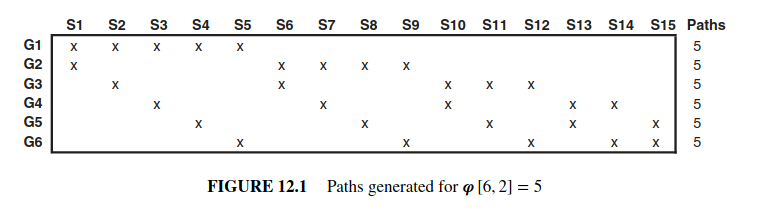

# TO BE CONTINUED